In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import seaborn as sns
import json
import torch
import pickle

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DeJavu Serif"


In [2]:
df_all = pd.DataFrame()

In [3]:
perp_folders = ["../output/10212023/"]

In [4]:

for perp_folder in perp_folders:
    files = os.listdir(perp_folder)
    files = [os.path.join(perp_folder, f) for f in files] # add path to each file
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    
    for file in files:        
        if "opposite" in file or "emb" in file or "predictions" in file or "proportions" in file:
            continue 
        
        if "english" not in file:
            continue 
                
        if ".log" in file:
            continue
        print(file)
        method = file.split("/")[-1]
        
        runs = os.listdir(file)
        
        for run in runs:
            if "proportions" in run:
                continue 
            seed = int(run.split("seed_")[-1].split("_")[0])
            checkpoint = int(run.split("-")[-1].split(".")[0])
            if len(df_all) != 0:
                if len(df_all.loc[(df_all.method==method) & (df_all.seed == seed) & (df_all.index==checkpoint)]) != 0:
                    continue 
                
            path = os.path.join(file, run)
            print(path)
                
            loss_dict = pd.read_pickle(path)
        
        
            df = pd.DataFrame([{"skill": k, "loss": [values.numpy() if torch.is_tensor(values) else values for values in v]} for k, v in loss_dict.items()])
            df["perplexity"] = pd.Series([np.exp(l) for l in df["loss"].values])
            df["average_loss"] = pd.Series([sum(l)/len(l) for l in df["loss"].values])
            df["average_perplexity"] = pd.Series([sum(p)/len(p) for p in df["perplexity"].values])
            df["method"] = method
            df["seed"] = seed
            df["checkpoint"] = checkpoint


            df.set_index("checkpoint", inplace=True)


            df_all = pd.concat([df_all, df])
    


../output/10212023/ni_xlingual_600_mixture_question_answering_english_english_question_answer_targetmask_0001_mean_spanish_qg_normalized_greedy_100_eta_0.8_lookback_3_checkpoints
../output/10212023/ni_xlingual_600_mixture_question_answering_english_english_question_answer_targetmask_0001_mean_spanish_qg_normalized_greedy_100_eta_0.8_lookback_3_checkpoints/seed_3_checkpoint-600.pkl
../output/10212023/ni_xlingual_600_mixture_question_answering_english_english_question_answer_targetmask_0001_mean_spanish_qg_normalized_greedy_100_eta_0.8_lookback_3_checkpoints/seed_0_checkpoint-300.pkl
../output/10212023/ni_xlingual_600_mixture_question_answering_english_english_question_answer_targetmask_0001_mean_spanish_qg_normalized_greedy_100_eta_0.8_lookback_3_checkpoints/seed_2_checkpoint-100.pkl
../output/10212023/ni_xlingual_600_mixture_question_answering_english_english_question_answer_targetmask_0001_mean_spanish_qg_normalized_greedy_100_eta_0.8_lookback_3_checkpoints/seed_1_checkpoint-400.pkl
.

In [5]:
def aggregate_skill(x, ppl=True):
    if ppl:
        total_ppl = x["perplexity"].apply(lambda x: sum(x)).sum()
        count_ppl = x["perplexity"].apply(lambda x: len(x)).sum()
        metric_name = "skill_perplexity"
        metric = total_ppl/count_ppl
    else:
        total_loss = x["loss"].apply(lambda x: sum(x)).sum()
        count_loss = x["loss"].apply(lambda x: len(x)).sum()
        metric_name = "skill_loss"
        metric = total_loss/count_loss

    names = {metric_name: metric}
    
    return pd.Series(names, index=[metric_name])



In [6]:
sorted(df_all.method.unique())

['ni_xlingual_600_mixture_question_answering_english_english_question_answer_targetmask_0001_mean_spanish_qg_normalized_greedy_100_eta_0.8_lookback_3_checkpoints',
 'ni_xlingual_600_mixture_question_answering_english_english_question_answer_weights_0001_static',
 'ni_xlingual_600_stratified_question_answering_english_english_question_answer_static']

[0 4 3 2 1]
checkpoint
600    3.101532
600    2.543172
600    3.271190
600    2.457139
Name: skill_loss, dtype: float64
[3 4 2 0 1]
checkpoint
600    2.660932
600    2.336460
600    2.815288
600    2.357324
Name: skill_loss, dtype: float64
[4 1 2 0 3]
checkpoint
600    2.716817
600    2.289134
600    2.873717
600    2.327529
Name: skill_loss, dtype: float64


Text(0.5, 1.0, 'Targeted learning of Spanish question generation')

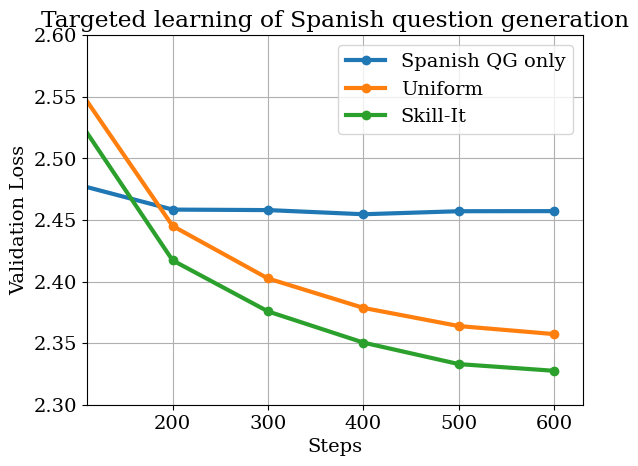

In [10]:


methods = ["ni_xlingual_600_mixture_question_answering_english_english_question_answer_weights_0001_static",
           "ni_xlingual_600_stratified_question_answering_english_english_question_answer_static",
           "ni_xlingual_600_mixture_question_answering_english_english_question_answer_targetmask_0001_mean_spanish_qg_normalized_greedy_100_eta_0.8_lookback_3_checkpoints"
]
plt.figure()
seeds=[0, 1, 2, 3, 4]

labels = ["Spanish QG only", "Uniform", "Skill-It"]

for i, method in enumerate(methods):
    
    df_shuffled = df_all.loc[df_all.method == method].sort_index()
    print(df_shuffled.seed.unique())
    df_shuffled = df_shuffled.loc[df_shuffled.seed.isin(seeds)]
    df_overall = df_shuffled.groupby([df_shuffled.index]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
    df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
    df_shuffled.set_index("checkpoint", inplace=True)
    df_overall.set_index("checkpoint", inplace=True)
    df_overall.drop([0], inplace=True)

    df_shuffled.loc[df_shuffled.skill == "question_generation_spanish_spanish"].skill_loss.plot(marker="o", label=labels[i], lw=3)
    print(df_shuffled.loc[df_shuffled.index == df_shuffled.index.max()].skill_loss)



plt.xlim(110, )
plt.ylim(2.3, 2.6)
plt.xlabel("Steps")
plt.ylabel("Validation Loss")
plt.legend(loc='upper right')
plt.grid()
plt.title("Targeted learning of Spanish question generation")
